<a href="https://colab.research.google.com/github/MustafaBozkurt84/predictive-maintanance-LSTM/blob/master/Arima1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install statsmodels --upgrade

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df =pd.read_csv("/content/drive/MyDrive/Datasets/predictive maintance /31_hidrolikmotoru_analiz.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.head()

,name,time,partno,vibx,vibz,spm,temp,zacc,zfreq,xkurt,crestfactor,balancerbasinci
0,sensorvib31,2020-01-01T00:00:01.70401Z,NaN,0.18,0.11,NaN,15.75,0.04,0.01,2.94,3.6,NaN
1,sensorvib31,2020-01-01T00:00:03.70467Z,NaN,0.18,0.11,NaN,15.75,0.04,0.01,2.94,3.6,NaN
2,sensorvib31,2020-01-01T00:00:05.70553Z,NaN,0.18,0.15,NaN,15.75,0.04,0.01,2.97,4.2,NaN
3,sensorvib31,2020-01-01T00:00:07.7093Z,NaN,0.16,0.15,NaN,15.75,0.05,0.01,3.11,4.5,NaN
4,sensorvib31,2020-01-01T00:00:09.70685Z,NaN,0.16,0.15,NaN,15.75,0.05,0.01,3.11,4.5,NaN


In [6]:
df.drop(["name","partno","balancerbasinci","spm","xkurt"],axis=1,inplace=True)

In [7]:
df.columns=['Time', 'vibx', 'vibz', 'temp', 'zacc', 'zfreq', 'crest']

In [8]:
#df = pd.read_excel("/content/drive/MyDrive/Datasets/predictive maintance /AnalizDataPM.xlsx",engine='openpyxl')
df["Time"]= [str(i).replace("2020-02-02","2/2/2020").replace("2020-01-02","2/1/2020") for i in df["Time"]]


In [9]:
df['Time'] = pd.to_datetime(df['Time']) 
df['Time']=[str(i).split(":")[0] for i in df["Time"]]

In [10]:
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S

In [11]:
df=df.groupby("Time").mean()
df.reset_index(inplace=True)
df.to_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
df.head()

,Time,vibx,vibz,temp,zacc,zfreq,crest
0,2020-01-01 00:00:00,0.154338,0.144321,15.637208,0.041157,0.01,4.111596
1,2020-01-01 01:00:00,0.156064,0.145520,15.373346,0.041440,0.01,4.160439
2,2020-01-01 02:00:00,0.155957,0.146585,15.122024,0.041997,0.01,4.212914
3,2020-01-01 03:00:00,0.155334,0.143598,14.902892,0.043065,0.01,4.331691
4,2020-01-01 04:00:00,0.157375,0.144605,14.703281,0.047041,0.01,4.693571


In [12]:
df.shape

(8287, 7)

In [13]:
for col in df.columns[1:]:
  df[col]=[round(i,2)for i in df[col]]

In [14]:
df1=df.copy()

In [15]:
df1['Time'] = [str(i).split()[0] for i in df1['Time']]
df1['Time'] = pd.to_datetime(df1['Time'],format="%Y-%m-%d")
df1.set_index("Time",inplace=True)



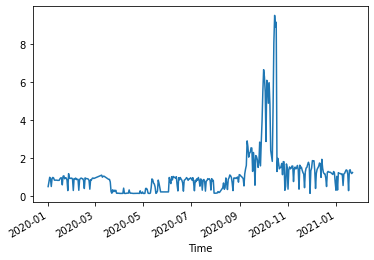

In [16]:
df1=df1.groupby("Time").mean()
df1.iloc[:,1].plot()

In [17]:
#df=pd.read_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv",parse_date=True)
#df=df.iloc[:,1:]


# ARIMA and Seasonal ARIMA


## Autoregressive Integrated Moving Averages

The general process for ARIMA models is the following:
* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model or Seasonal ARIMA based on the data
* Use the model to make predictions

Let's go through these steps!

In [18]:
df_vibx = df.loc[:,["Time","vibx"]]
df_vibz = df.loc[:,["Time","vibz"]]
df_temp = df.loc[:,["Time","temp"]]
df_zacc = df.loc[:,["Time","zacc"]]
df_crest = df.loc[:,["Time","crest"]]
df_zfreq = df.loc[:,["Time","zfreq"]]

In [19]:
dataframes=[df_vibx,df_vibz,df_temp,df_zacc,df_crest,df_zfreq]

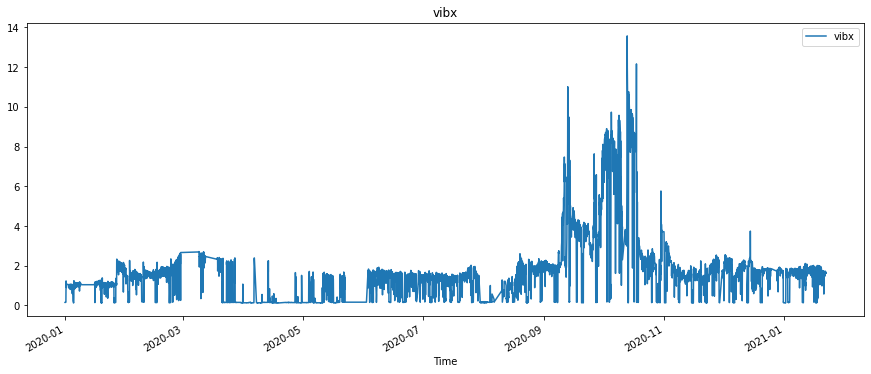

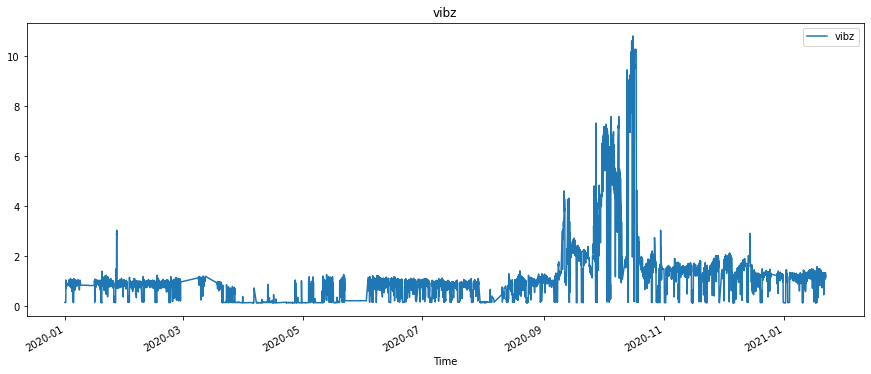

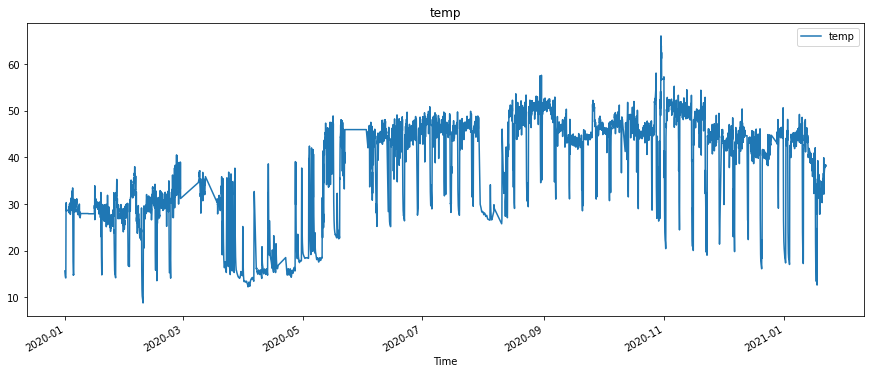

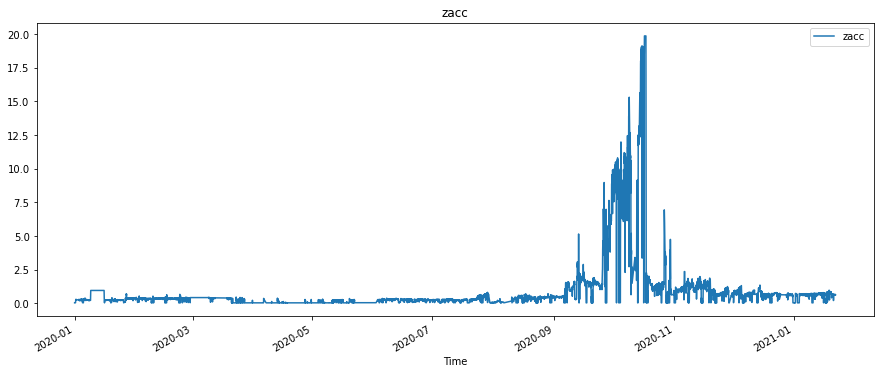

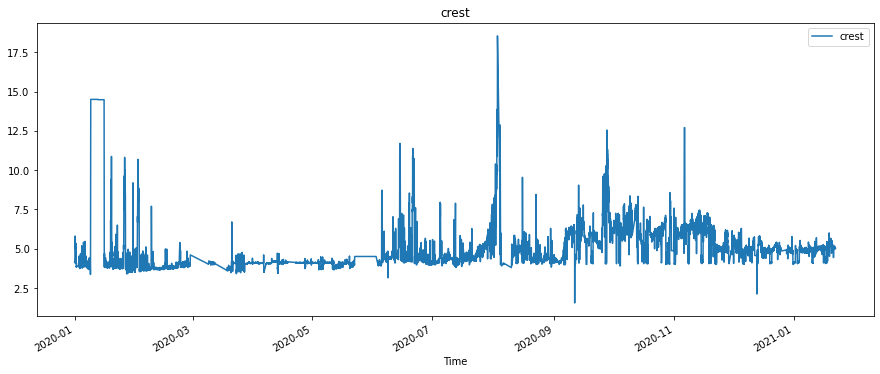

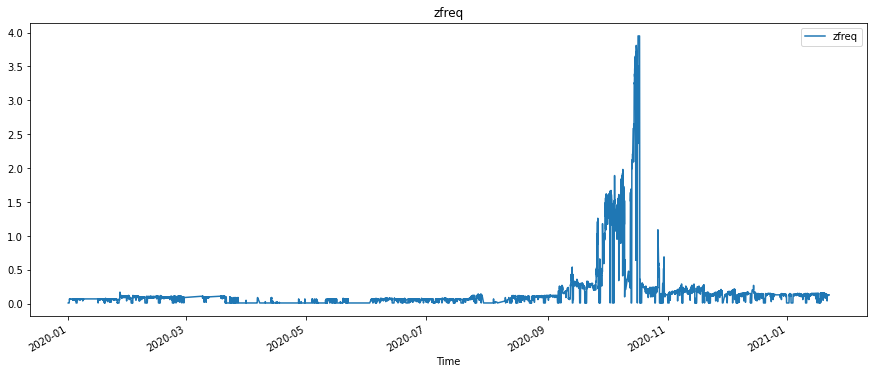

In [20]:
for data in dataframes:
    data.set_index("Time",inplace=True)
    data.index = pd.DatetimeIndex(data.index)
    data.plot(figsize=(15, 6))
    plt.title(data.columns[0])

In [21]:
df.describe()

,vibx,vibz,temp,zacc,zfreq,crest
count,8287.000000,8287.000000,8287.000000,8287.000000,8287.000000,8287.000000
mean,1.653758,1.153970,37.287937,0.986399,0.172637,5.016678
std,1.706521,1.382143,11.326339,2.419017,0.412699,1.777174
min,0.120000,0.120000,8.770000,0.030000,0.010000,1.540000
25%,0.220000,0.210000,28.365000,0.090000,0.010000,4.080000
50%,1.520000,0.950000,42.640000,0.360000,0.080000,4.420000
75%,1.950000,1.300000,45.970000,0.750000,0.140000,5.340000
max,13.570000,10.820000,66.040000,19.850000,3.950000,18.540000


In [22]:
from statsmodels.tsa.stattools import adfuller

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(col,colname):
    print("-"*20 + f"{colname}"+ 20*"-")
    result=adfuller(col)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    print(20*"*")


In [23]:
for col in df.columns[1:]:
  adfuller_test(df.loc[:,col],col)

--------------------vibx--------------------
ADF Test Statistic : -4.625139933189619
p-value : 0.00011606744761418964
#Lags Used : 36
Number of Observations Used : 8250
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
********************
--------------------vibz--------------------
ADF Test Statistic : -5.075424276324736
p-value : 1.570503682672467e-05
#Lags Used : 35
Number of Observations Used : 8251
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
********************
--------------------temp--------------------
ADF Test Statistic : -4.770624296166808
p-value : 6.187771036329662e-05
#Lags Used : 31
Number of Observations Used : 8255
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
********************
--------------------zacc--------------------
ADF Test Statistic : -5.048196509682

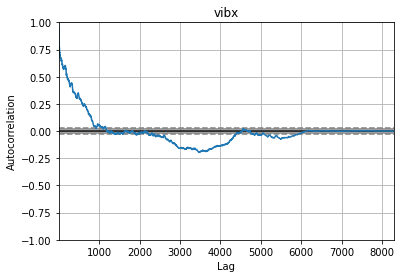

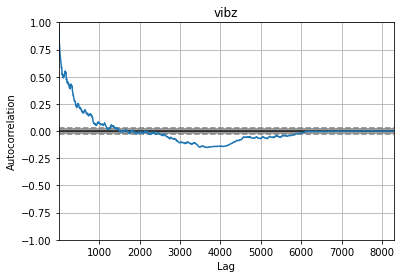

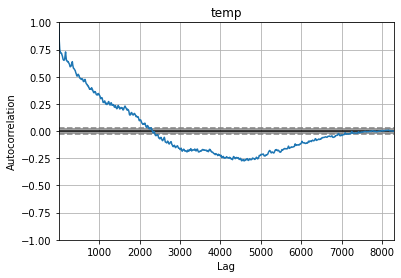

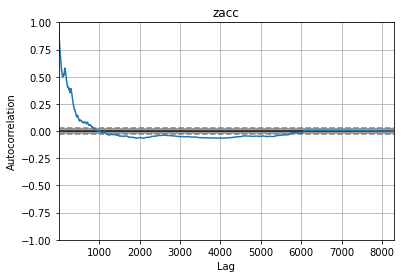

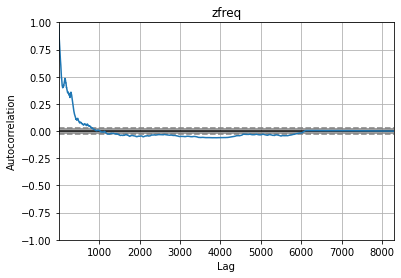

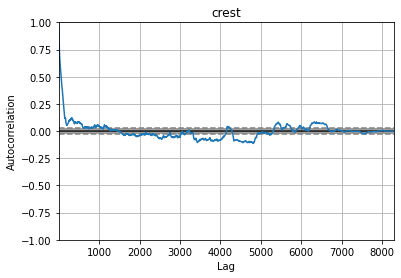

In [24]:
from pandas.plotting import autocorrelation_plot
for col in df.columns[1:]:
  autocorrelation_plot(df[col])
  plt.title(f"{col}")
  plt.show()

### Final Thoughts on Autocorrelation and Partial Autocorrelation

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.
    
    p,d,q
    p AR model lags
    d differencing
    q MA lags

In [25]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
def Autocorrelation_plot(df,col):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(df[col],lags=40,ax=ax1)
    ax2 = fig.add_subplot(212)
    ax1.set_title(f" Autocorrelation ({col}) ")
    fig = plot_pacf(df[col],lags=40,ax=ax2)
    ax2.set_title(f" Partial Autocorrelation ({col})")
    

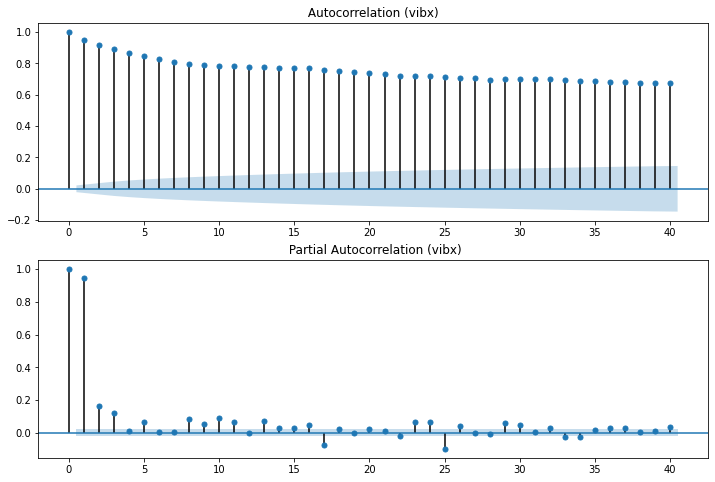

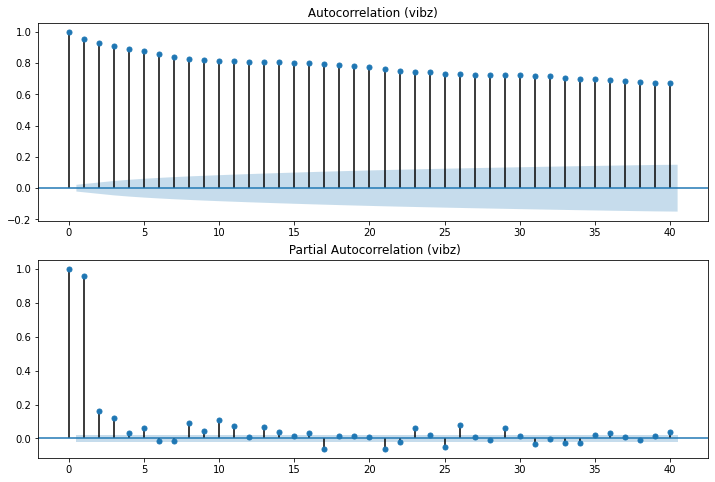

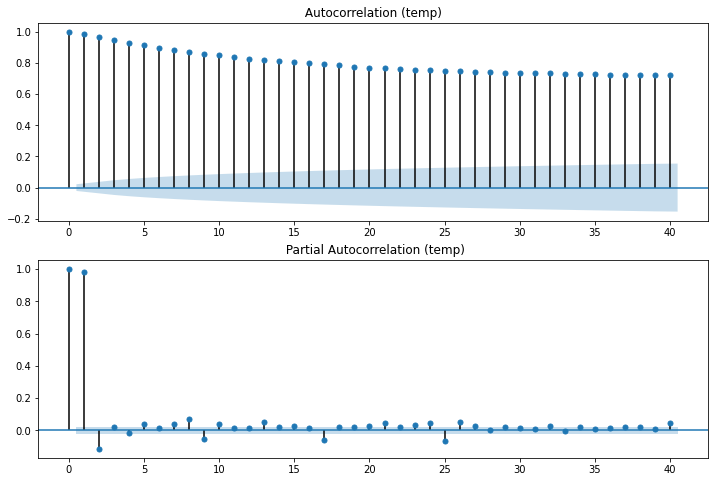

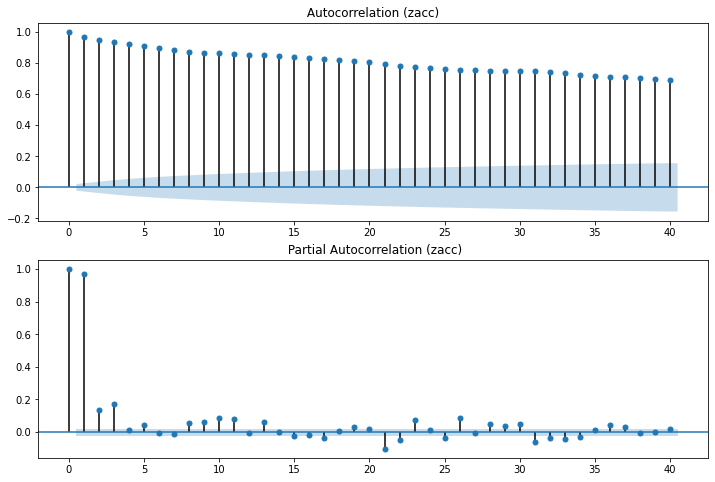

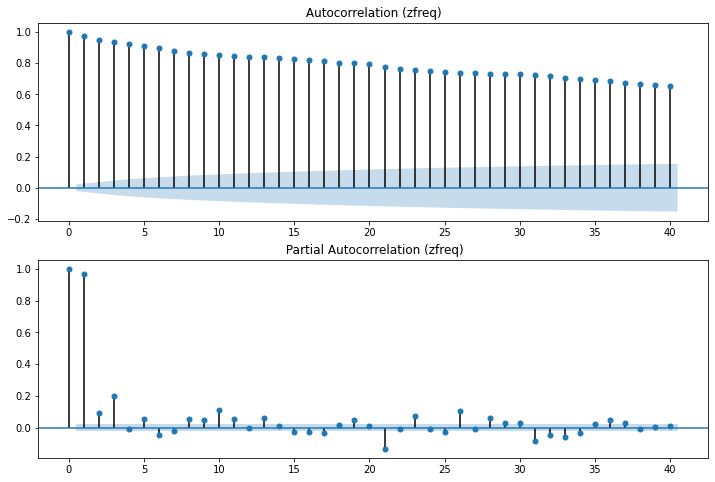

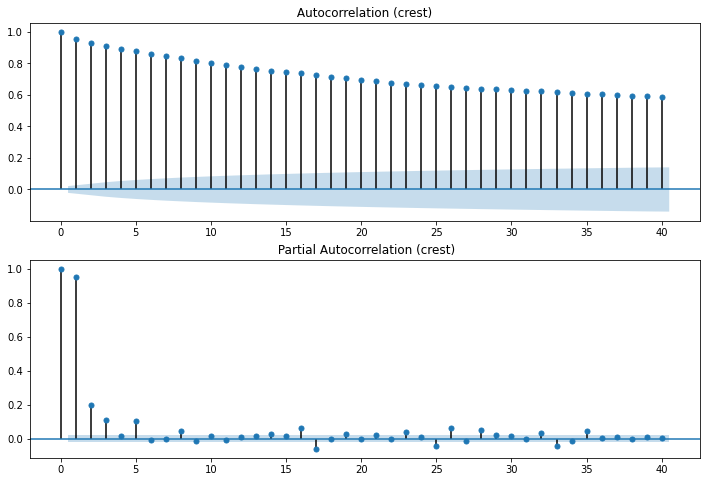

In [26]:
for col in df.columns[1:]:
  Autocorrelation_plot(df,col)

In [27]:
!pip install pmdarima

In [28]:

from pmdarima import auto_arima


In [29]:

for i in df1.columns:
    print(50*"*")
    print(i)
    stepwise_fit = auto_arima(df1[i], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

**************************************************
vibx
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=815.933, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=1355.625, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=793.257, Time=0.41 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=978.979, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1619.353, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=882.540, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=787.795, Time=0.85 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=788.702, Time=2.43 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=786.720, Time=0.72 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=822.411, Time=0.31 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=788.701, Time=1.37 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=803.211, Time=0.65 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=790.711, Time=1.31 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=1105.143, Ti

In [30]:
 def pickle_all(key,value):
         pickle_out = open("/content/drive/MyDrive/model_predictive_maintanence/"+key+"_arima.pkl", "wb")
         pickle.dump(value, pickle_out)
         pickle_out.close()

In [31]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
import statsmodels.api as sm

In [32]:
def arima_model(df,col,date,date1,p,d,q,p1,d1,q1,m):
    #df.index = pd.DatetimeIndex(df.index)
    df["arıza"]=df[col]
    df["arıza"]=np.where((df["Time"]>"2020-01-27 14:00:00")&(df["Time"] <"2020-01-27 16:00:00"),df[col].max(),df[col].min())
    #model=ARIMA(df[df.index < date][col],order=(p,d,q))
    model=sm.tsa.statespace.SARIMAX(df[(df["Time"]>date)&(df["Time"]<date1)][[col]],order=(p, d, q),seasonal_order=(p1,d1,q1,m))
    
    model_fit=model.fit()
    pickle_all(col,model_fit)
    
    print(model_fit.summary())
    print(df.head())
    df2=df[df.index<800][[col]]
    df2['forecast_'+col]=model_fit.predict(start=df2.index[0],end=df2.index[-1])
    df2["arıza"]=df["arıza"]
    df2[[col,'forecast_'+col,"arıza"]].iloc[:600].plot(figsize=(12,8))
    df2["Dif"] = ((df2[col]-df2['forecast_'+col])/df2[col])
    return df2

In [ ]:
df2=arima_model(df,"vibx","2020-02-02 17:00:00","2020-02-21 14:00:00",2,0,2,1,0,1,7*24) #(2,0,2)(1,0,1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: U

In [ ]:
df2

In [ ]:
arima_model(df,"vibz","2020-01-28 00:00:00","2020-02-21 14:00:00",1,0,0,1,0,1,24*7) #(1,0,0)(1,0,1) 

In [ ]:
arima_model(df,"temp","2020-01-28 00:00:00","2020-02-21 14:00:00",1,0,0,1,0,0,24*7) #(3,0,0)(2,0,0)

In [ ]:
arima_model(df,"zacc","2020-01-28 00:00:00","2020-02-21 14:00:00",1,0,0,1,0,0,24*7) #(3,0,0)(2,0,0)

In [ ]:
arima_model(df,"crest","2020-01-28 00:00:00","2020-02-21 14:00:00",1,0,0,1,0,0,7*24) #(1,0,0)(0,0,0)

In [ ]:
arima_model(df,"zfreq","2020-01-28 00:00:00","2020-02-21 14:00:00",1,0,1,1,0,1,7*24) #(3,0,0)(1,0,0)

In [ ]:
for i in df.columns:
  print(f"{i} sensoru  {df[df[i]==df[i].max()].index[0]} de en yuksek degerı olan {df[i].max()} degerını kaydetmis ")


In [ ]:
"""vibx sensoru  2020-01-27 04:00:00 de en yuksek degerı olan 2.3257780256553273 degerını kaydetmis 
vibz sensoru  2020-01-27 05:00:00 de en yuksek degerı olan 3.027547281323874 degerını kaydetmis 
temp sensoru  2020-01-27 05:00:00 de en yuksek degerı olan 35.27760047281316 degerını kaydetmis 
zacc sensoru  2020-01-27 03:00:00 de en yuksek degerı olan 0.7172621035058485 degerını kaydetmis 
crest sensoru  2020-01-19 13:00:00 de en yuksek degerı olan 10.865886603668711 degerını kaydetmis 
zfreq sensoru  2020-01-27 03:00:00 de en yuksek degerı olan 0.17328324986088234 degerını kaydetmis """